# Kaggle: Housing Prices 

In this notebook we explore the [housing prices kaggle challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) with Google Colab.  


For this challenge, I will use Keras+Tensorflow and other python libraries.

## Getting Started

At the moment, I'm not sure how I can clone a github repository into Google Colab and open a notebook from that repository (this notebook is copied into my Google Drive). 
So, this notebook will clone the [figment](https://github.com/demarley/figment) repository to access the kaggle dataset.


In [1]:
!git clone https://github.com/demarley/figment.git

Cloning into 'figment'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 85 (delta 34), reused 62 (delta 20), pack-reused 0
Unpacking objects: 100% (85/85), done.


In [2]:
# Now we can check that the repository has been cloned and has the data
!ls 

figment  sample_data


## The Wilderness Must Be Explored!

With the dataset accessible, let's initially do some exploratory analysis to understand what data we have and what it looks like.  To do this I will use traditional python libraries, especially matplotlib, because those are the ones with which I am most familiar and I'm trying to incrementally introduce new things (hopefully I won't get too lost too quickly!).*

Furthermore, I've spent the better part of the last decade doing physics research and building an intuition for different features and how they relate between signals and backgrounds.  So, since I'm venturing into a new area, I'm going to take a bit of time to understand what data we're given and how different features affect the `SalePrice`.

*_I'm familiar with the seaborn package, but at the moment I don't see its benefits over something like the latest versions of matplotlib (2.2+)._

In [0]:
import numpy as np
import pandas as pd
import matplotlib.style
import matplotlib as mpl
mpl.style.use("default")
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

np.random.seed(2019)

In [0]:
df = pd.read_csv("figment/housing-prices/data/train.csv");

### Quantifying Data

From the description file we know that some of these columns contain text rather than numerical data.  
I want to give numerical codes to these values (assuming at the moment that there is a finite number of options for these values) to possibly use them directly in the solution and visualize them with pandas.

In [12]:
str_data = {}
for i in df.columns:
    if isinstance(df[i][0],str):
        str_data[i] = list(set(df[i]))
        print(i,set(df[i])) # print the name of the column and unique values

MSZoning {'RH', 'FV', 'C (all)', 'RL', 'RM'}
Street {'Grvl', 'Pave'}
LotShape {'IR2', 'IR3', 'IR1', 'Reg'}
LandContour {'Lvl', 'Bnk', 'Low', 'HLS'}
Utilities {'AllPub', 'NoSeWa'}
LotConfig {'FR2', 'Inside', 'Corner', 'FR3', 'CulDSac'}
LandSlope {'Gtl', 'Sev', 'Mod'}
Neighborhood {'Gilbert', 'SWISU', 'Crawfor', 'NoRidge', 'Blmngtn', 'BrkSide', 'NPkVill', 'MeadowV', 'Veenker', 'Mitchel', 'Somerst', 'NAmes', 'OldTown', 'NWAmes', 'ClearCr', 'NridgHt', 'Edwards', 'Timber', 'Sawyer', 'BrDale', 'IDOTRR', 'CollgCr', 'Blueste', 'SawyerW', 'StoneBr'}
Condition1 {'RRNn', 'PosN', 'Feedr', 'RRAe', 'PosA', 'RRNe', 'Norm', 'Artery', 'RRAn'}
Condition2 {'RRNn', 'PosN', 'Feedr', 'RRAe', 'PosA', 'Norm', 'Artery', 'RRAn'}
BldgType {'2fmCon', '1Fam', 'TwnhsE', 'Twnhs', 'Duplex'}
HouseStyle {'1Story', '1.5Fin', 'SFoyer', 'SLvl', '2.5Fin', '2.5Unf', '2Story', '1.5Unf'}
RoofStyle {'Mansard', 'Shed', 'Flat', 'Gable', 'Hip', 'Gambrel'}
RoofMatl {'Tar&Grv', 'CompShg', 'WdShake', 'Roll', 'Membran', 'ClyTile', 'W

For each of these values, we will assign a number 0-N for the N unique values in the dataframe.
All of the `nan` values will receive a value of `-1`.

In [0]:
# First get all of the unique column names (except 'NaN')
values = []
cols   = list(str_data.keys())

for k in cols:
    for sd in str_data[k]:
        try:
            np.isnan(sd)
        except TypeError:
            if sd not in values: values.append(sd)

# Next, let's assign an integer to each name
allvalues = {}
for v,val in enumerate(values):
    allvalues[val] = v

Now that we have unique integer values for each text value, let's update the dictionary

In [0]:
df = df.fillna(-1)  # fill NaNs with '-1'

In [0]:
for k in cols:
    for val in str_data[k]:
        try:
            np.isnan(val)
        except TypeError:
            df.loc[df[k] == val, k] = allvalues[val]

(array([ 35., 618., 649., 121.]),
 array([107.  , 107.75, 108.5 , 109.25, 110.  ]),
 <a list of 4 Patch objects>)

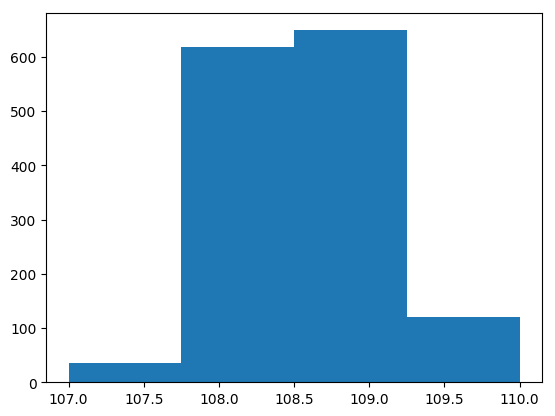

In [16]:
# Check that some of these worked
data = df['BsmtQual'].values
plt.hist(data[np.where(data>0)],bins=4)

### Making Some Plots

Visualizing the different distributions & looking at correlations help me to understand what kind of data I have.  
To that end, let's start making plots and trying to understand which features might be best for predicting the sale price.

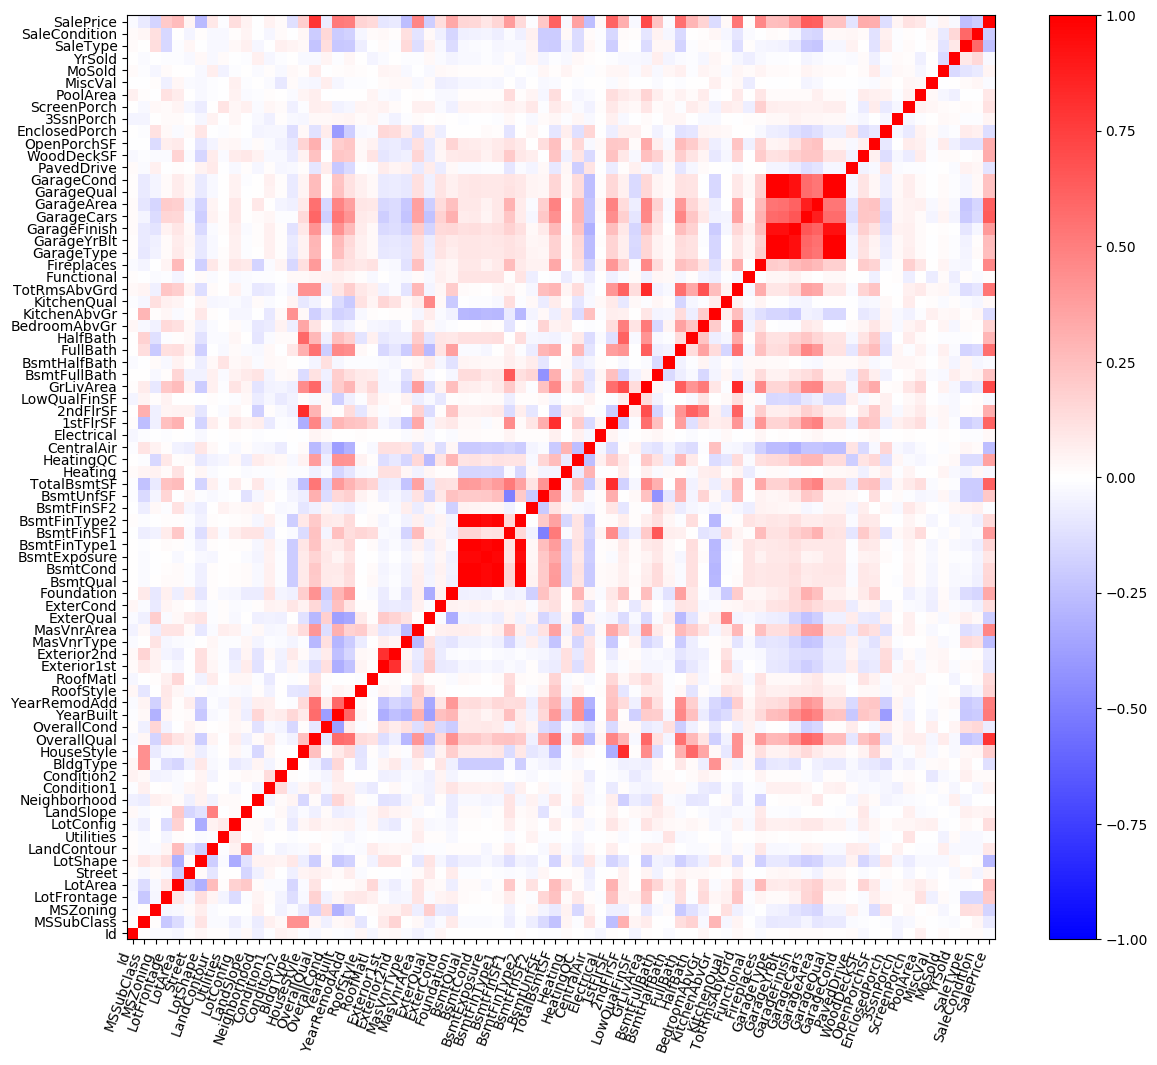

In [17]:
corrmat = df.corr()

fig,ax  = plt.subplots(figsize=(14,12))

opts    = {'cmap':plt.get_cmap("bwr"),'vmin':-1,'vmax':1}
heatmap = plt.pcolor(corrmat, **opts)
cbar    = plt.colorbar(heatmap, ax=ax)

labels = corrmat.columns.values

# shift location of ticks to center of the bins
ax.set_xticks(np.arange(len(labels))+0.5, minor=False);
ax.set_yticks(np.arange(len(labels))+0.5, minor=False);
ax.set_xticklabels(labels, fontsize=10, minor=False, ha='right', rotation=70);
ax.set_yticklabels(labels, fontsize=10, minor=False);

There are quite a few features, many of them don't seem to be strongly correlated (given the largely "white" matrix).  
As expected, many related variables are strongly correlated, e.g., the basement, garage, and bathroom features.  
Beyond that, let's start looking at some of these that are correlated with sale price to see if it's possible to only use a few features to get great performance.

In [18]:
vals = corrmat.SalePrice.values
med = np.median(vals)
rms = np.std(vals)
print("Distribution: {0:.2f} +/- {1:.2f}".format(med,rms))

Distribution: 0.13 +/- 0.27


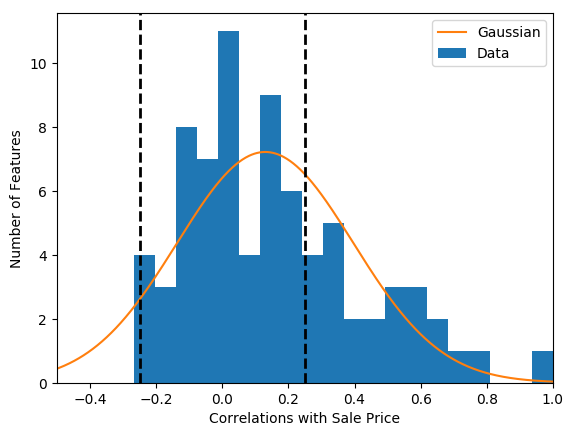

In [19]:
n = 1000
x = np.linspace(-1,1,n)
y = (1 / (np.sqrt(2 * np.pi * np.power(rms, 2)))) * \
    (np.power(np.e, -(np.power((x - med), 2) / (2 * np.power(rms, 2)))))

h,b,p = plt.hist(vals,bins=20,label="Data");
widths   = b[1:] - b[:-1]
integral = np.sum(h * widths)
plt.plot(x,integral*y,label="Gaussian")

plt.xlim(-0.5,1.0)
plt.xlabel("Correlations with Sale Price")
plt.ylabel("Number of Features")
plt.axvline(x=0.25,lw=2,ls='--',color='k')
plt.axvline(x=-0.25,lw=2,ls='--',color='k')
plt.legend()

So, it looks like most correlation values are close to 0.0. 
However, there are some larger (positive) correlations.  Let's look closer at those where `|rho|>0.25`

In [20]:
# Positive Correlations
corrmat[corrmat.SalePrice>0.25].SalePrice

LotArea         0.263843
OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472585
Foundation      0.337133
BsmtFinSF1      0.386420
TotalBsmtSF     0.613581
HeatingQC       0.366542
1stFlrSF        0.605852
2ndFlrSF        0.319334
GrLivArea       0.708624
FullBath        0.560664
HalfBath        0.284108
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageType      0.253588
GarageYrBlt     0.261354
GarageFinish    0.391253
GarageCars      0.640409
GarageArea      0.623431
WoodDeckSF      0.324413
OpenPorchSF     0.315856
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [21]:
# Negative Correlations
corrmat[corrmat.SalePrice<-0.25].SalePrice

LotShape     -0.265699
MasVnrType   -0.256615
CentralAir   -0.251328
Name: SalePrice, dtype: float64

In particular, let's look more closely at these larger negative correlations.

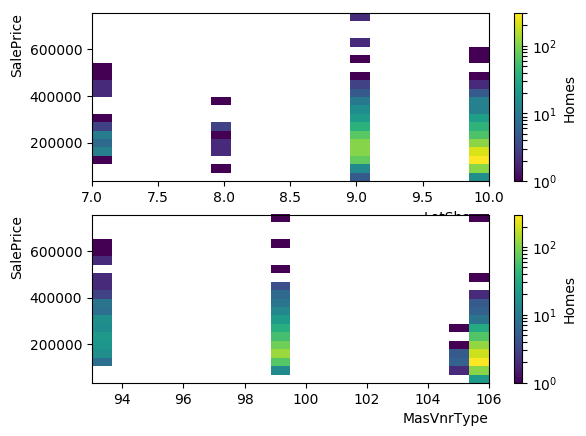

In [22]:
fig,ax = plt.subplots(2,1)

plt.subplot(2,1,1)
plt.hist2d(df.LotShape,df.SalePrice,bins=20,cmap='viridis',norm=LogNorm());
plt.colorbar(label="Homes");
plt.ylabel("SalePrice",position=(0,1),ha='right');
plt.xlabel("LotShape",position=(1,0),ha='right');

plt.subplot(2,1,2)
plt.hist2d(df[df.MasVnrType>0].MasVnrType,df[df.MasVnrType>0].SalePrice,bins=20,cmap='viridis',norm=LogNorm());
plt.colorbar(label="Homes");
plt.ylabel("SalePrice",position=(0,1),ha='right');
plt.xlabel("MasVnrType",position=(1,0),ha='right');

We can see that these represent two of the columns that had textual data I converted into numerical data.  So, we can check exactly what's going on:

In [23]:
for feature in ['MasVnrType','LotShape']:
    print(feature,str_data[feature])
    for i in str_data[feature]:
        try:
            np.isnan(i)
        except TypeError:
            print(i,allvalues[i])

MasVnrType [nan, 'BrkCmn', 'None', 'Stone', 'BrkFace']
BrkCmn 105
None 106
Stone 93
BrkFace 99
LotShape ['IR2', 'IR3', 'IR1', 'Reg']
IR2 7
IR3 8
IR1 9
Reg 10


For now, I will leave this as it is, but this may be something we need to revisit and hand-label the textual data values to get 'proper' correlations.

Now let's just make a few other plots to understand the different correlations that revealed themselves above.

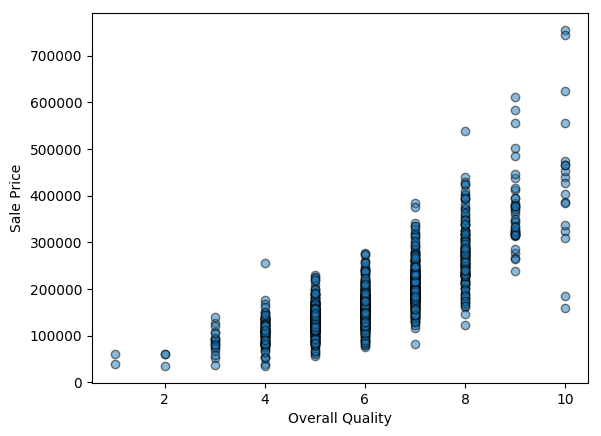

In [24]:
# The largest correlation belonged to `OverallQual`, let's check that first
plt.scatter(df['OverallQual'],df['SalePrice'],edgecolor='k',alpha=0.5);
plt.ylabel("Sale Price");
plt.xlabel("Overall Quality");

The scatter plot is nice, but the points are so dense I would rather plot this as a 2d histogram.

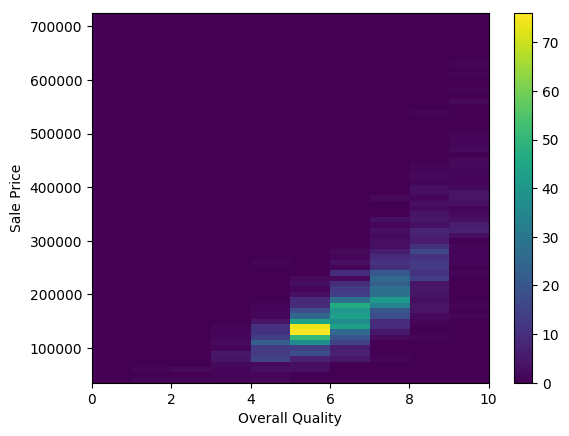

In [25]:
binning = [range(11),[34900+i*10000 for i in range(70)]]    # modify bins
plt.hist2d(df['OverallQual'],df['SalePrice'],bins=binning);
plt.ylabel("Sale Price");
plt.xlabel("Overall Quality");
plt.colorbar()

Let's look beyond just `OverallQual` for a moment:

In [26]:
# Set an arbitrary threshold of 0.5 to check correlations
corr_threshold = 0.5
poscorrs = np.abs(corrmat[np.abs(corrmat.SalePrice)>corr_threshold].SalePrice)
poscorrs.sort_values()

YearRemodAdd    0.507101
YearBuilt       0.522897
TotRmsAbvGrd    0.533723
FullBath        0.560664
1stFlrSF        0.605852
TotalBsmtSF     0.613581
GarageArea      0.623431
GarageCars      0.640409
GrLivArea       0.708624
OverallQual     0.790982
SalePrice       1.000000
Name: SalePrice, dtype: float64

For values with (absolute value) correlations above 0.5, there are only 10 features that meet this criteria, and none of them are correlated stronger than 0.8. 

Before going too far, let's check how correlated each of these are with each other!

In [27]:
params = poscorrs.keys()
tmp = corrmat[np.abs(corrmat.SalePrice)>corr_threshold][params]

tmp

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
OverallQual,1.000000,0.572323,0.550684,0.537808,0.476224,0.593007,0.550600,0.427452,0.600671,0.562022,0.790982
YearBuilt,0.572323,1.000000,0.592855,0.391452,0.281986,0.199010,0.468271,0.095589,0.537850,0.478954,0.522897
YearRemodAdd,0.550684,0.592855,1.000000,0.291066,0.240379,0.287389,0.439046,0.191740,0.420622,0.371600,0.507101
TotalBsmtSF,0.537808,0.391452,0.291066,1.000000,0.819530,0.454868,0.323722,0.285573,0.434585,0.486665,0.613581
1stFlrSF,0.476224,0.281986,0.240379,0.819530,1.000000,0.566024,0.380637,0.409516,0.439317,0.489782,0.605852
GrLivArea,0.593007,0.199010,0.287389,0.454868,0.566024,1.000000,0.630012,0.825489,0.467247,0.468997,0.708624
FullBath,0.550600,0.468271,0.439046,0.323722,0.380637,0.630012,1.000000,0.554784,0.469672,0.405656,0.560664
TotRmsAbvGrd,0.427452,0.095589,0.191740,0.285573,0.409516,0.825489,0.554784,1.000000,0.362289,0.337822,0.533723
GarageCars,0.600671,0.537850,0.420622,0.434585,0.439317,0.467247,0.469672,0.362289,1.000000,0.882475,0.640409
GarageArea,0.562022,0.478954,0.371600,0.486665,0.489782,0.468997,0.405656,0.337822,0.882475,1.000000,0.623431


In [28]:
# The smallest correlation between all of the values:
np.min(np.abs(tmp.values))
# And in the matrix that looks like it comes from `TotRmsAbvGrd` and `YearBuilt`

0.0955891282979514

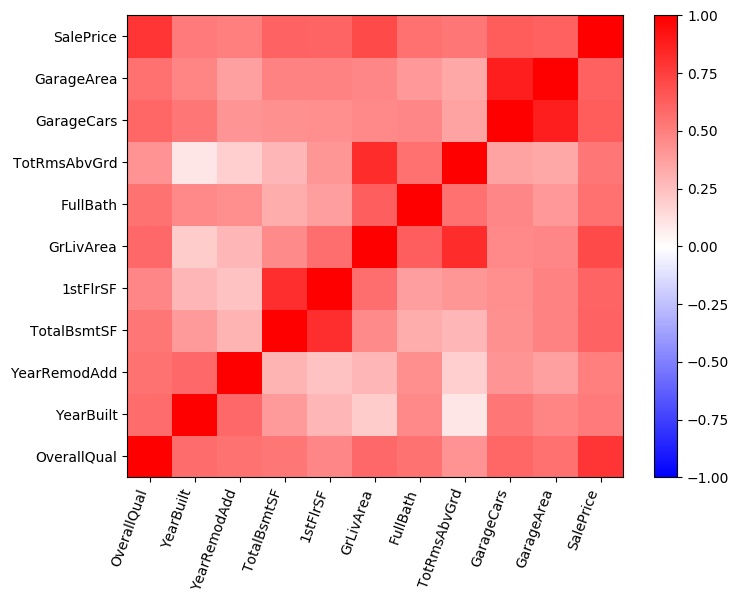

In [29]:
# plot the reduced correlation matrix
fig,ax  = plt.subplots(figsize=(8,6))

opts    = {'cmap':plt.get_cmap("bwr"),'vmin':-1,'vmax':1}
heatmap = plt.pcolor(tmp, **opts)
cbar    = plt.colorbar(heatmap, ax=ax)

labels = params

# shift location of ticks to center of the bins
ax.set_xticks(np.arange(len(labels))+0.5, minor=False);
ax.set_yticks(np.arange(len(labels))+0.5, minor=False);
ax.set_xticklabels(labels, fontsize=10, minor=False, ha='right', rotation=70);
ax.set_yticklabels(labels, fontsize=10, minor=False);

Unfortunately, it appears that all of these are also strongly correlated with each other!

Now that I've looked through these values, I'm feeling a little more comfortable trying out some solutions.

##  Initial Attempts at a Solution

My first attempt at doing this will be incredibly simple and basic.
Because I know that the `OverallQual` feature is most strongly correlated with `SalePrice`, I'm going to start with using only that feature in a couple different ways to predict the outcome.


Given all of the data points in the training set, I will pick 75% at random, do a linear fit to the scatter plot data of `SalePrice` vs `OverallQual`, and use the remaining 25% of the data to test this prediction.

In [0]:
# Import some new modules
from sklearn.model_selection import train_test_split  # want to make 'training' and 'validation' samples to test performance
from sklearn.metrics import explained_variance_score  # quantifying accuracy of regression

In [0]:
# First, let's slice the dataframe into 'training' and 'validation' sets
tmp = df.sample(frac=1) # shuffle the dataframe rows
tts = train_test_split(df['OverallQual'].values,\
                       df['SalePrice'].values, \
                       test_size=0.25)
X_train,X_test,Y_train,Y_test = tts

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


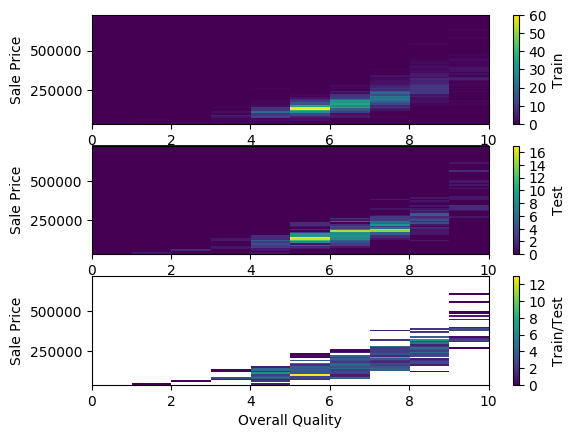

In [32]:
# let's check the differences between the test and train datasets
binning = [range(11),[34900+i*10000 for i in range(70)]]    # modify bins

fig,ax = plt.subplots(3,1)

plt.subplot(3, 1, 1)
train_h,train_bx,train_by = np.histogram2d(X_train,Y_train,bins=binning)
plt.hist2d(X_train,Y_train,bins=binning);
plt.ylabel("Sale Price");
plt.colorbar(label="Train")


plt.subplot(3, 1, 2)
test_h,test_bx,test_by = np.histogram2d(X_test,Y_test,bins=binning)
plt.hist2d(X_test,Y_test,bins=binning);
plt.ylabel("Sale Price");
plt.colorbar(label="Test")


plt.subplot(3, 1, 3)
# Take ratio, flatten and use as weights to make histogram (with dummy binning)
ratio   = np.divide(train_h,test_h).flatten()
center_x = 0.5*(test_bx[:-1]+test_bx[1:])
center_y = 0.5*(test_by[:-1]+test_by[1:])
dummy_x  = center_x.repeat(len(center_y))
dummy_y  = np.tile(center_y, (1,len(center_x)))[0]

plt.hist2d(dummy_x,dummy_y,bins=binning,weights=ratio);
plt.ylabel("Sale Price");
plt.xlabel("Overall Quality");
plt.colorbar(label="Train/Test")

plt.show()

Given the disparity in values (75% vs 25%) and fine binning, I don't see any cause for concern with how the dataset was split in the plots.

To be safe, let's do a quick calculation to determine the compatibility between the training and validation datasets, using [separation](https://root.cern.ch/doc/master/MethodBase_8cxx_source.html#l02740):

In [0]:
def getSeparation( sig,bkg ):
    """
    Calculate separation between two numpy arrays
    Returned values will be between 0 and 1
      - separation = 0: Arrays have identical contents (complete overlap)
      - separation = 1: Arrays have unique contents (no overlap)
    """
    try:
        matching_shapes = sig.shape==bkg.shape
    except AttributeError:
        matching_shapes = len(sig)==len(bkg)
    sig_sum  = np.all(sig==0)
    bkg_sum  = np.all(bkg==0)
    zero_sum = np.all(sig+bkg==0)

    if not matching_shapes: return -1
    if zero_sum or sig_sum or bkg_sum: return -1

    sig = np.divide(sig,np.sum(sig),dtype=np.float32)
    bkg = np.divide(bkg,np.sum(bkg),dtype=np.float32)
    tmp = np.divide( (sig-bkg)**2 , (sig+bkg), dtype=np.float32)
    tmp = np.nan_to_num(tmp)    # set NaN to 0; INF to large number
    separation = tmp.sum()*0.5

    return separation

In [34]:
getSeparation(train_h,test_h)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


0.11342988163232803

I would be more comfortable if this were less than 0.1, but we'll use it for now.

### First Approach: Linear Regression
Let's do the linear fit! Luckily `scipy` has this already built-in for us:

In [35]:
from scipy import stats

# Do the fit!
slope, intercept, r_value, p_value, std_err = stats.linregress(X_train,Y_train)
print(f"Slope     = {slope}")
print(f"Intercept = {intercept}")
print(f"R-vale    = {r_value}")
print(std_err)

Slope     = 45718.61348029157
Intercept = -97785.44546003823
R-vale    = 0.7939884065007503
1058.8256552464456


Now that we have the fit, let's make some plots and check how well it looks on the training and validation sets.

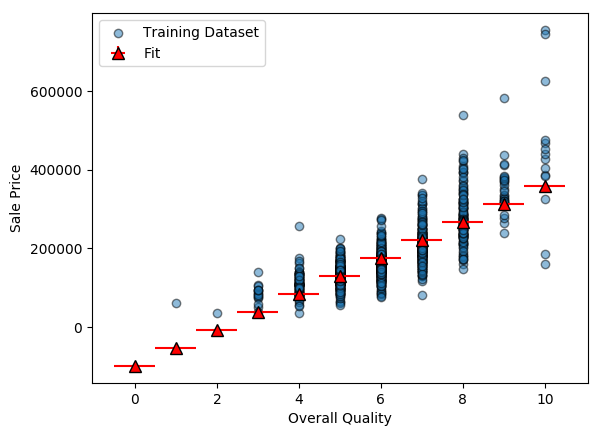

In [36]:
plt.scatter(X_train,Y_train,edgecolor='k',alpha=0.5,label="Training Dataset");
plt.errorbar(range(11),[slope*i+intercept for i in range(11)],\
             fmt='^',ms=9,mfc='r',mec='k',ecolor='r',\
             yerr=std_err,xerr=0.5,label='Fit')  # errorbar points at each 'OverallQual' value
plt.xlabel("Overall Quality");
plt.ylabel("Sale Price");
plt.legend()

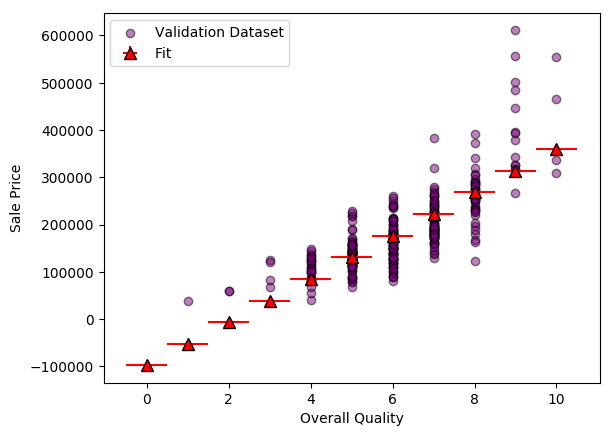

In [37]:
# And now plot with the 'validation' set
plt.scatter(X_test,Y_test,color='purple',edgecolor='k',alpha=0.5,label="Validation Dataset");
plt.errorbar(range(11),[slope*i+intercept for i in range(11)],\
             fmt='^',ms=9,mfc='r',mec='k',ecolor='r',\
             yerr=std_err,xerr=0.5,label='Fit')  # errorbar points at each 'OverallQual' value
plt.xlabel("Overall Quality");
plt.ylabel("Sale Price");
plt.legend()

And now plot the differences between the predicted sale price and the actual sale price in the validation set to see how well it does!

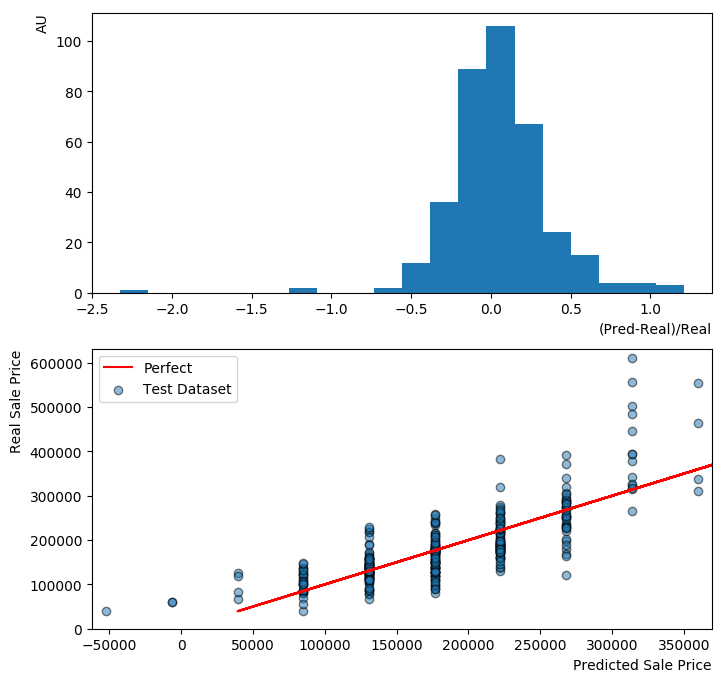

In [38]:
# Prediction: y=m*x+b
X_val = X_test.copy()
predictions = slope*X_val + intercept
values = np.divide((predictions - Y_test),Y_test)

fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')

plt.subplot(2,1,2)
plt.scatter(predictions,Y_test,edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test,Y_test,color='r',label="Perfect")
plt.xlim(min(predictions)-10000,max(predictions)+10000)
plt.ylim(0,max(Y_test)+20000)
plt.xlabel("Predicted Sale Price",position=(1,0),ha='right')
plt.ylabel("Real Sale Price",position=(0,1),ha='right')
plt.legend()

In [42]:
# Look at some stats on the relative difference:
print(" > Distribution = {0:.2f} +/- {1:.2f}".format(np.mean(values),np.std(values)))

# We can also attempt to quantify our performance
evs = explained_variance_score(Y_test,predictions)
print(" > EV Score     = {0:.3f}".format(evs))

 > Distribution = 0.05 +/- 0.32
 > EV Score     = 0.611


For the linear fit, there are some striking issues:


1.   The prediction produces a negative value for low quality homes!
2.   The predicted values are grouped based on the `OverallQual` because only a single, identical value is predicted for the same input value.

A remedy to issue #1 may be to try a different technique.
To fix #2, we should use MVA techniques (explored in the other notebooks).


### Second Approach: Quadratic Fit

Instead of a linear fit to the data as done above, I will now try a quadratic fit to see if there is any improvement in the results.

In [0]:
# Easy enough, numpy can do this:
deg2,deg1,intercept = np.polyfit(X_train,Y_train,2)

Now that we have the polynomial fit, we can plot the fit against the training and validation sets.

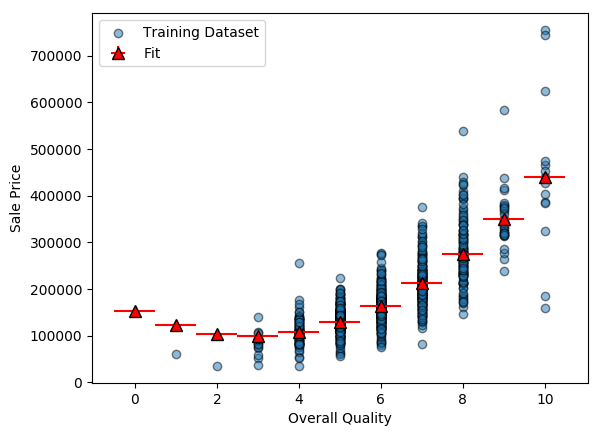

In [44]:
plt.scatter(X_train,Y_train,edgecolor='k',alpha=0.5,label="Training Dataset");
plt.errorbar(range(11),[deg2 * i**2 + deg1*i + intercept for i in range(11)],\
             fmt='^',ms=9,mfc='r',mec='k',ecolor='r',\
             yerr=std_err,xerr=0.5,label='Fit')  # errorbar points at each 'OverallQual' value
plt.xlabel("Overall Quality");
plt.ylabel("Sale Price");
plt.legend()

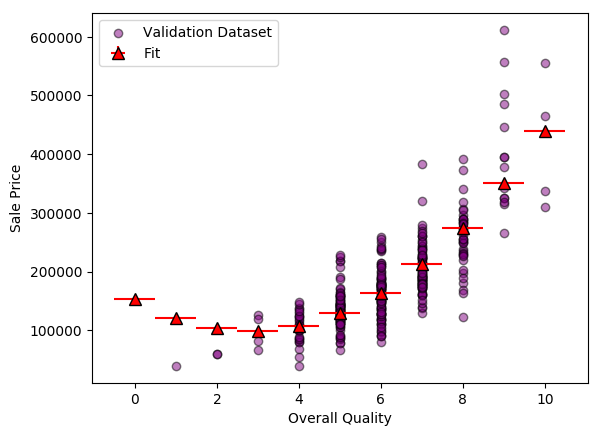

In [45]:
# And now plot with the 'validation' set
plt.scatter(X_test,Y_test,color='purple',edgecolor='k',alpha=0.5,label="Validation Dataset");
plt.errorbar(range(11),[deg2 * i**2 + deg1*i + intercept for i in range(11)],\
             fmt='^',ms=9,mfc='r',mec='k',ecolor='r',\
             yerr=std_err,xerr=0.5,label='Fit')  # errorbar points at each 'OverallQual' value
plt.xlabel("Overall Quality");
plt.ylabel("Sale Price");
plt.legend()

And now we can plot against the prediction to see if we did any better!

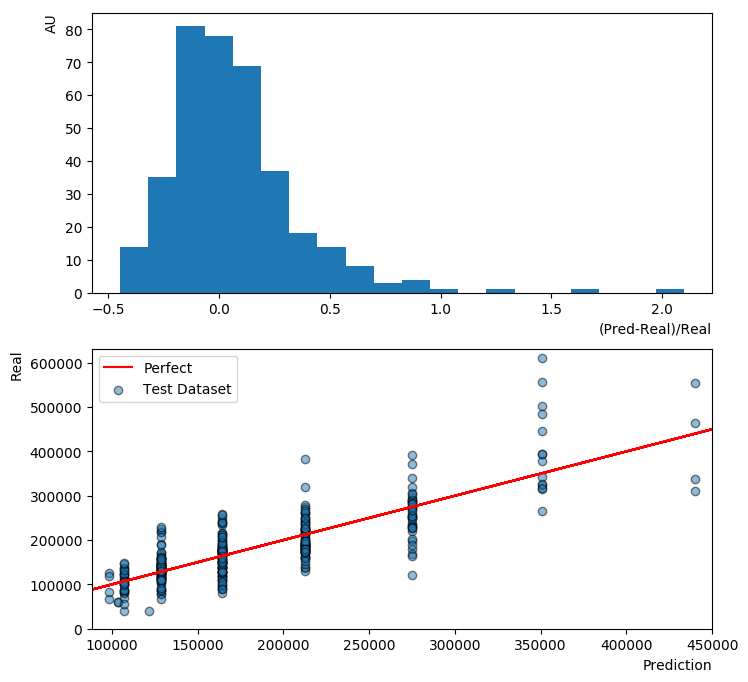

In [46]:
# Prediction: y=m*x+b
X_val = X_test.copy()
predictions = deg2 * np.square(X_val) + deg1*X_val + intercept
values = np.divide((predictions - Y_test),Y_test)

fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')

plt.subplot(2,1,2)
plt.scatter(predictions,Y_test,edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test,Y_test,color='r',label="Perfect")
plt.xlim(min(predictions)-10000,max(predictions)+10000)
plt.ylim(0,max(Y_test)+20000)
plt.xlabel("Prediction",position=(1,0),ha='right')
plt.ylabel("Real",position=(0,1),ha='right')
plt.legend()

In [47]:
# Look at some stats on the relative difference:
print(" > Distribution = {0:.2f} +/- {1:.2f}".format(np.mean(values),np.std(values)))

# We can also attempt to quantify our performance
evs = explained_variance_score(Y_test,predictions)
print(" > EV Score     = {0:.3f}".format(evs))

 > Distribution = 0.07 +/- 0.29
 > EV Score     = 0.673


In compensating for the poor predictions at low quality values, we now overestimate the prices of the houses!  However, we do have an improved EVS, so there is something gained by using a quadratic fit instead of a linear one :)

### Post-mortem 

There are obvious issues with these approaches.  
Namely, the prediction will always be the same for a particular value for `OverallQual`, no matter what the other features are (which leads to the odd distribution in the scatter plots above).  This can be addressed by looking at MVA techniques, done in the other notebooks.

### Third Approach: Gaussian Variability

Another simple technique can address this issue -- to some extent.  
In this instance, we will still use only `OverallQual` to predict the outcome, but we will allow for some variability.

For each value of `OverallQual`, let's determine the mean and RMS of the `SalePrice`(from the training set).  
Then, when we are given a new `OverallQual` value, we sample from a Gaussian with the pre-determined values for mean and RMS. 

In [0]:
# Start with the training set and find the RMS in each bin of `OverallQual`
df_slices = []

# loop over different values for OverallQual
for i in range(11):
    df_slices.append(Y_train[np.where(X_train==i)[0]])

Now let's calculate the mean and RMS for each value of `OverallQual` and use that to predict the `SalePrice`

In [0]:
class SalePrice:
    def __init__(self,mean,rms):
        self.mean = mean
        self.rms  = rms

In [0]:
sp_values = []      # the index of sp_values refers to the `OverallQual` value
for i in range(11):
    values = df_slices[i]
    if len(values)>0:
        mean = np.mean(values)
        rms  = np.std(values)
    else:
        mean = 0
        rms  = 0
    sp = SalePrice(mean,rms)
    sp_values.append(sp)

Now we can visualize the distributions by plotting the mean and rms on top of the 2d histogram

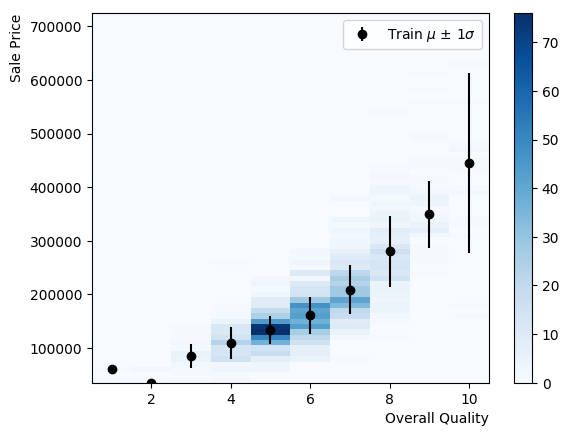

In [51]:
# Let's plot the distributions real quick
binning = [[i+0.5 for i in range(11)],[34900+i*10000 for i in range(70)]]    # modify bins
plt.hist2d(df['OverallQual'],df['SalePrice'],bins=binning,cmap="Blues");
plt.colorbar()

plt.errorbar(range(11),[i.mean for i in sp_values],yerr=[i.rms for i in sp_values],color='k',fmt='o',label=r"Train $\mu$ $\pm$ 1$\sigma$");
plt.xlabel("Overall Quality",position=(1,0),ha='right')
plt.ylabel("Sale Price",position=(0,1),ha='right')
plt.legend()

Given there are zero entries for `OverallQual==0`, we can just ignore that entry (in the data description, there is no value 0 allocated).

Now, with the set of `mean` and `rms` values, let's make some predictions!

In [0]:
g_predictions = []

for i,e in enumerate(X_test):
    sample = np.random.normal( sp_values[e].mean, sp_values[e].rms )
    g_predictions.append(sample)

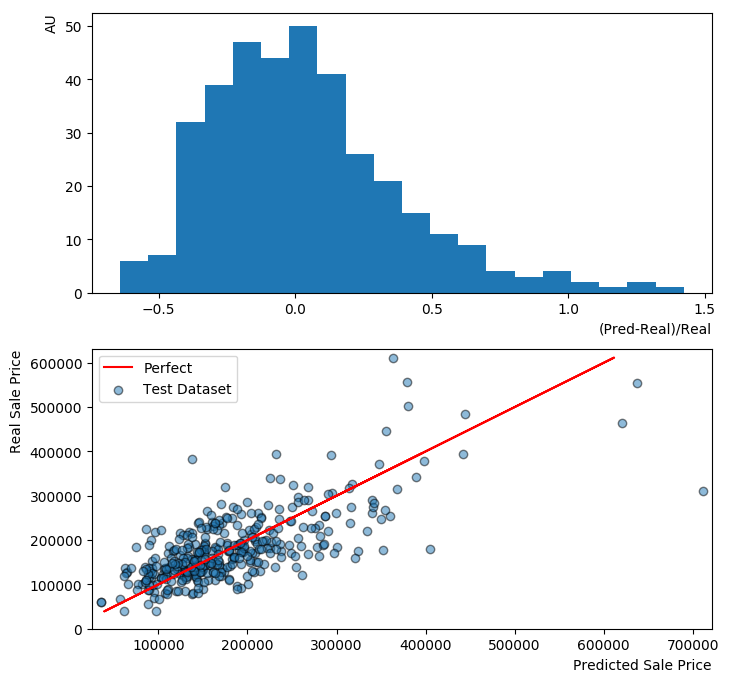

In [53]:
# Prediction: Gaussian sampling
values = np.divide((np.asarray(g_predictions) - Y_test),Y_test)

fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')

plt.subplot(2,1,2)
plt.scatter(g_predictions,Y_test,edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test,Y_test,color='r',label="Perfect")
plt.xlim(min(g_predictions)-10000,max(g_predictions)+10000)
plt.ylim(0,max(Y_test)+20000)
plt.xlabel("Predicted Sale Price",position=(1,0),ha='right')
plt.ylabel("Real Sale Price",position=(0,1),ha='right')
plt.legend()

In [54]:
# Look at some stats on the relative difference:
print(" > Distribution = {0:.2f} +/- {1:.2f}".format(np.mean(values),np.std(values)))

# We can also attempt to quantify our performance
evs = explained_variance_score(Y_test,g_predictions)
print(" > EV Score     = {0:.3f}".format(evs))

 > Distribution = 0.04 +/- 0.35
 > EV Score     = 0.377


While we have a more diverse set of predictions (no longer binned by `OverallQual`), there are still noticeable issues with the spread in the prediction that can be improved.  Furthermore, it appears our EVS went down -- substantially :/ 

### Fourth Approach: Machine Learning

In the next notebook, we will explore more sophisticated multivariate techniques for doing the regression.  It's clear that using just one variable does not produce very good results and adding more variables should (hopefully) improve our prediction.